# Textklassifikation

In dieser Übung werden wir das *[20newsgroups](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset)* Datenset benutzen um ein besseres Verständnis für Kernelmethoden und Klassifikation zu bekommen. Unser Ziel ist es, eine Reihe von Nachrichtenmeldungen 11 unterschiedlichen Kategorien zuzuordnen. Wir gehen dabei in zwei Schritten vor:
- Vorbereitung der Daten mittels Feature Extraction/Vectorization
- Klassifikation mittels Linear/Kernel SVM (Kapitel 4.2.3)

In [4]:
# Stelle sicher, dass das Internet (unter Settings auf der rechten Seite) für das 
# Notebook aktiviert ist, damit das Herunterladen der Daten funktioniert.

from sklearn.datasets import fetch_20newsgroups

categories = [
    'alt.atheism',
    'comp.graphics',
    'misc.forsale',
    'rec.autos',
    'rec.motorcycles',
    'sci.electronics',
    'sci.space',
    'soc.religion.christian',
    'talk.politics.guns',
    'talk.politics.mideast',
    'talk.politics.misc',
]

data_train = fetch_20newsgroups(subset="train", shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'), categories=categories)
data_test = fetch_20newsgroups(subset="test", shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'), categories=categories)

In [5]:
import numpy as np
X_train, y_train = data_train.data, data_train.target
X_test, y_test = data_test.data, data_test.target
len(X_train), len(y_train), len(np.unique(y_test))

(6199, 6199, 11)

Das Trainingsset enthält 11315 Nachrichtenmeldungen, welche 20 verschiedenen Kategorien zugewiesen sind. Diese Kategorien finden im Attribut `target_names`. Wir verwenden allerdings nur 11 dieser Kategorien, damit das Datenset nicht zu groß und die Rechenzeiten nicht zu lange werden. Das gibt uns 6200 Texte.

In [20]:
data_train.target_names

['alt.atheism',
 'comp.graphics',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'sci.electronics',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc']

Das Targetset `y_train` ist einfach ein *numpy array*, `X_test` ist jedoch eine Python Liste:

In [21]:
type(X_train), type(y_train)

(list, numpy.ndarray)

Wenn wir das erste Element ansehen, dann stellen wir fest, dass es sich bei jeder Instanz um den ursprünglichen Text handelt. Dies stellt uns schon vor die erste Herausforderung, da die meisten Machine Learning Methoden numerische Daten (in Matrixform) benötigen. Unsere erste Aufgabe ist es daher diese Daten in die entsprechende Form zu bringen. Dazu können wir verschiedene *[Feature Extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)* Methoden verwenden.

In [22]:
print(f"{categories[y_train[0]]},", y_train[0], "\n", X_train[0])

rec.autos, 3 
 
the transmission in my car contradicts both your assertions..  i get much
stronger acceleration if i let the convertor lockup.. which i can induce
by briefly lifting off,  then quickly (but not too quickly to trigger
a kickdown) applying throttle.  above 3000 rpms, the convertor will never
unlock;  it would kickdown first.

who says there's no skill involved in driving an automatic?  i think
of it as the throttle and shifter combined into a single pedal.  with
my car i can pretty much influence its shifting patterns with my
right foot, while having both hands to steer.



## 2a) Vektorisierungsmethoden
Vektorisierung bedeutet nichts anderes als einen Text in Vektorform zu bringen. Dazu gibt es verschiedene Möglichkeiten. Die einfachste ist ein sogenannter [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer). Dabei wird aus dem Text-Datenset ein Vokabular erstellt und die einzelnen Terme werden für jeden Text gezählt. 

Der folgende Code bringt das ursprüngliche Set in Matrixform indem es den `CountVectorizer` verwendet. Die Vektorisierung hat ein Vokabular mit 52426 Einträgen erstellt.  

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

extractor = CountVectorizer()
X_train_vec = extractor.fit_transform(X_train)
print(X_train_vec.shape)

(6199, 52425)


Leider erzeugt dieser Vektorizer auch sehr viele schlechte Features welche nur in einem oder zwei Texten vorkommen. Wir können den Parameter `min_df` erhöhen um zu erzwingen, dass jeder Term (*Token*) mindestens in `min_df` Texten vorkommen muss. Man kann einen Integer Wert verwenden oder einen Float zwischen 0.0 und 1.0, welcher den Prozentsatz angibt. Im folgenden Beispiel ist `min_df=5` und man kann sehen, dass das Vokabular schon etwas kleiner ist (11839 Einträge). 

In [24]:
extractor = CountVectorizer(min_df=5)
X_train_vec = extractor.fit_transform(X_train)
print(X_train_vec.shape)

(6199, 11838)


Wir haben immer noch das Problem, dass unsere Vektorisierung viele unnütze Features erzeugt. Hier ist ein Code, welcher die *Document Frequency* der einzelnen *Token* ausgibt.


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

def sort_dict(d):
    return dict(sorted(d.items(), key=lambda x: x[1]))

def document_frequency(X_train, **kwargs):
    """
    Calculates the document frequency of a given set. 
    """
    m = len(X_train)
    extractor = TfidfVectorizer(**kwargs)
    X_train_vec = extractor.fit_transform(X_train)
    # inverse of idf
    df = (1 + m) / np.exp(extractor.idf_ - 1) - 1 
    df = df.astype(np.int64)
    vocabulary = sort_dict(extractor.vocabulary_)  # sort by index
    return sort_dict({k: df[i] for (i, k) in enumerate(vocabulary.keys())})  # sort by df

def print_df(df, n):
    """
    Prints first `n` items in df.
    """
    for token in list(df.items())[:n]:
        print(token)

print_df(document_frequency(X_train, min_df=3), 40)

('00072', 3)
('0013', 3)
('008', 3)
('011', 3)
('014', 3)
('02139', 3)
('0300', 3)
('0674', 3)
('074', 3)
('0826', 3)
('0952', 3)
('0a', 3)
('0b', 3)
('0l', 3)
('0v', 3)
('0x', 3)
('10000', 3)
('100mhz', 3)
('101010', 3)
('1030', 3)
('1047', 3)
('107', 3)
('1070', 3)
('1074', 3)
('1091', 3)
('10m', 3)
('10mhz', 3)
('10w', 3)
('110v', 3)
('116', 3)
('1200cc', 3)
('1201', 3)
('120mph', 3)
('120v', 3)
('1224', 3)
('123', 3)
('1244', 3)
('1280', 3)
('128k', 3)
('1290', 3)


Der `CountVectorizer` ist eine sehr einfache Methode der Vektorisierung. Wenn wir `min_df` erhöhen, dann wird das Datenset zwar kleiner, jedoch werden auch viele Terme ignoriert, welche potentielle Informationen enthalten. Wir werden eine etwas kompliziertere Methode verwenden: [*Term Frequency $\times$ inverse Document Frequency*](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting). Die Implementierung findet sich in der Klasse `TfidfVectorizer`. Mit dieser Methode lassen sich oft bessere Modelle erstellen. Der folgende Code soll den Unterschied zwischen *Term Frequency* und *Document Frequency* noch einmal verdeutlichen.

In [26]:
import numpy as np
import pandas as pd
from itertools import chain
from collections import defaultdict
df = defaultdict(int)

doc1 = "Cat Dog Raven Cat"
doc2 = "Raven Dog Dog Cow"

tf_doc1 = {term: count for (term, count) in zip(*np.unique(np.array(doc1.split(' ')), return_counts=True))}
tf_doc2 = {term: count for (term, count) in zip(*np.unique(np.array(doc2.split(' ')), return_counts=True))}

for term in chain(tf_doc1.keys(), tf_doc2.keys()):
    df[term] += 1  # 

df = dict(df)
dataframe = pd.DataFrame.from_records([tf_doc1, tf_doc2]).fillna(0).astype(int)
dataframe = dataframe.append(df, ignore_index=True)
dataframe.index = ["tf_doc1", "tf_doc2", "df"]
dataframe


C:\Users\natsc\AppData\Local\Temp\ipykernel_33460\2818077137.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(df, ignore_index=True)


,Cat,Dog,Raven,Cow
tf_doc1,2,1,1,0
tf_doc2,0,2,1,1
df,1,2,2,1


In [27]:
#!pip install nltk

In [28]:
from nltk import download

In [29]:

download('stopwords')
download('wordnet')
download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natsc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natsc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\natsc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Wir können sehen, dass viele Features nicht besonders aussagekräftig sind. Jedoch beinhalten manche wertvolle Informationen. Zum Beispiel kann man annehmen, dass `120mph` ein Hinweis auf die Kategorie `rec.autos` oder `rec.motorcycles` ist. Anstatt diese Token einfach zu entfernen ist es sinnvoll sie vorher umzuwandeln. Zum Beispiel können wir `120mph` mit `__SPEED__` ersetzen. 
Der folgende Code benutzt eine eigene Implementierung des `tokenizer`. Dieser spaltet einen Text in seine Bestandteile auf und wir können jeden Term einzeln bearbeiten.

- Schreibe eine weitere Regel, welche alle Nummern + `kwh, mhz, miles, k, mi, usd` u.s.w. mit `__UNIT__` ersetzt. Z.B.: `100kwh` mit `__UNIT__`.
- Schreibe eine weitere Regel, welche alle Token die mindestens eine Nummer enthalten mit `__ALPHANUMERIC__` ersetzt.
- Wie viele Werte wurden ersetzt? Dafür kannst du wieder die Funktion `document_frequency` von vorhin verwenden.

In [30]:
# kwh, mhz, miles, k, mi, usd

In [31]:
token = "3mhz"
token.endswith(tuple(["kwh", "mhz", "miles", "k", "mi", "usd"]))

True

In [32]:
# number = re.compile(r'\b[0-9]')
# bool(number.match("8k"))

In [33]:
import re

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

reg_tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')  # (?u) = unicode, \b = word boundary \w\w+ = word with at least 2 characters
lemmatizer = WordNetLemmatizer()
stopwords_en = set(stopwords.words('english'))


def valid(token):
    return (token not in stopwords_en and token != "")

floating_number = re.compile(r'^[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?$')
def is_decimal(token):
    return bool(floating_number.match(token))
    
int_number = re.compile(r'^[-+]?[0-9]+$')
def is_integer(token):
    return bool(int_number.match(token))

def is_number(token):
    return is_decimal(token) or is_integer(token)

alphanumeric = re.compile(r'[0-9]+')
def is_alphanumeric(token):
    return bool(alphanumeric.match(token))
    
def is_year(token):
    return len(token) == 4 and token.startswith(("18", "19", "20")) and is_integer(token)

numberunit = re.compile(r'^\d+[a-zA-Z]+$')
def is_speed(token):
    return bool(numberunit.match(token)) and token.endswith("mph")

unit = re.compile(r'\b[0-9]')
def is_unit(token):
    return bool(unit.match(token)) and token.endswith(("kwh", "mhz", "miles", "k", "mi", "usd"))


def preprocess_token(token):
    token = token.strip("_").lower()
    if token == "": return ""

    if is_year(token): return "__YEAR__"
    if is_number(token): return "__NUMBER__"
    if is_speed(token): return "__SPEED__"
    if is_unit(token): return "__UNIT__"
    if is_alphanumeric(token): return "__ALPHANUMERIC__"
    return token

def tokenizer(text):
    text = reg_tokenizer.tokenize(text)
    text = map(preprocess_token, text)
    text = filter(valid, text)
    return map(lemmatizer.lemmatize, text)

df = document_frequency(X_train, tokenizer=tokenizer, min_df=3)
print_df(df, 40)

('a2i', 3)
('aamir', 3)
('abdomen', 3)
('abdul', 3)
('abdullah', 3)
('abide', 3)
('abominable', 3)
('aborted', 3)
('abridged', 3)
('absolutist', 3)
('absorber', 3)
('acad3', 3)
('academia', 3)
('academically', 3)
('acc', 3)
('accel', 3)
('accolade', 3)
('accomodate', 3)
('accomodation', 3)
('accompany', 3)
('accomplis', 3)
('accomplishing', 3)
('accomplishment', 3)
('accorded', 3)
('accounted', 3)
('accredited', 3)
('accumulated', 3)
('accuses', 3)
('accusing', 3)
('accussations', 3)
('accustomed', 3)
('achieves', 3)
('ack', 3)
('acknowledgement', 3)
('acknowledges', 3)
('acknowledging', 3)
('acorn', 3)
('acquainted', 3)
('activation', 3)
('actor', 3)


In [34]:
print("__NUMBER__:", df["__NUMBER__"])
print("__SPEED__:", df["__SPEED__"])
print("__YEAR__:", df["__YEAR__"])
print("__ALPHANUMERIC__:", df["__ALPHANUMERIC__"])
print("__UNIT__:", df["__UNIT__"])

__NUMBER__: 2618
__SPEED__: 35
__YEAR__: 820
__ALPHANUMERIC__: 1037
__UNIT__: 181


## 2b) Kernel Methoden und SVMs für Textklassifikation
- Erstelle jetzt eine Pipeline welche diese `tokenizer` verwendet. Die erste Stufe sollte ein `TfidfVectorizer` sein, gefolgt von einer `SVC`.
- Benutze `GridSearchCV` um nach passenden Hyperparametern zu suchen (ignoriere den Parameter `gamma`, der Defaultwert ist gut genug für den Anfang). Vergleiche verschiedene Kerne (z.B.: `"linear", "rbf"` oder  die `cosine_similarity` Funktion). Verwende den `f1_score` als Metrik. Setze dazu `scoring=score` in `GridSearchCV`. Wenn die Trainingszeit zu lange ist, dann verwende einen niedrigeren Wert für `cv`. Du kannst auch den Wert `n_jobs` erhöhen.

In [35]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score
import numpy as np

def score(model, X, y):
    y_pred = model.predict(X)
    return f1_score(y, y_pred, average='macro')

In [36]:
def feature_map_1(X):
    return np.array([X[0],X[1],X[1]*X[0]])
def my_kernel_1(X,Y):
    return np.dot(feature_map_1(X),feature_map_1(Y).T )
#dont work not 2d

In [37]:

kernel_svm_clf = Pipeline([
 ("scaler", TfidfVectorizer(tokenizer=tokenizer)),
 ("svm_clf", SVC(kernel="rbf"))
 ])


In [38]:
# K(X, Y) = <X, Y> / (||X||*||Y||) cosine similarity

In [39]:

kernels = ["linear", "rbf",cosine_similarity,"poly"]#my_kernel_1]
param_grid = [{
    "svm_clf__kernel" : kernels
 }]
grid_search = GridSearchCV(kernel_svm_clf,param_grid=param_grid)
grid_search.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler',
                                        TfidfVectorizer(tokenizer=<function tokenizer at 0x00000199718D9280>)),
                                       ('svm_clf', SVC())]),
             param_grid=[{'svm_clf__kernel': ['linear', 'rbf',
                                              <function cosine_similarity at 0x0000019971079670>,
                                              'poly']}])

- Berechne die Wahrheitsmatrix deines Modelles anhand des Trainingssets. 
- Normalisiere die Matrix indem du durch die Summe der Zeilen dividierst und die Diagonale 0 setzt.
- Plotte die normalisierte Matrix. Was kannst du sehen?

In [40]:
pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm_clf__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,22.403352,0.188333,4.032794,0.044535,rbf,{'svm_clf__kernel': 'rbf'},0.801613,0.779839,0.780645,0.789516,0.775626,0.785448,0.009261,1
0,18.901564,0.234761,3.498691,0.032304,linear,{'svm_clf__kernel': 'linear'},0.792742,0.768548,0.781452,0.786290,0.771590,0.780124,0.009009,2
2,7.528847,0.327807,1.746728,0.100830,<function cosine_similarity at 0x0000019971079...,{'svm_clf__kernel': <function cosine_similarit...,0.792742,0.768548,0.781452,0.786290,0.771590,0.780124,0.009009,2
3,23.593358,0.676279,4.182848,0.118794,poly,{'svm_clf__kernel': 'poly'},0.625806,0.598387,0.619355,0.641129,0.597256,0.616387,0.016731,4


In [41]:
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [42]:
y_pred_test = cross_val_predict(grid_search.best_estimator_, X_test, y_test, cv=3)


In [43]:
def norm_matrix(A):
    dim = A.shape[0]
    B = np.zeros((dim,dim))
    for j in range(0,dim):
        b = A[j] /  A[j].sum()
        B[j] = b
    np.fill_diagonal(B,0)
    return B

In [44]:
norm_conf_mx = confusion_matrix(y_test,y_pred_test)

In [45]:
A = norm_conf_mx

In [46]:
A[0] / A[0].sum()

array([0.53918495, 0.01880878, 0.00940439, 0.03134796, 0.09404389,
       0.02821317, 0.05642633, 0.14420063, 0.04388715, 0.02507837,
       0.00940439])

In [47]:
# norm_matrix(norm_conf_mx)

In [48]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred):
    norm_conf_mx = confusion_matrix(y_true,y_pred) # Berechne die Wahrheitsmatrix und normalisiere!
    norm_conf_mx = norm_matrix(norm_conf_mx)
    fig, ax = plt.subplots(1,1, figsize=(10,10)) 
    ax.matshow(norm_conf_mx, cmap=plt.cm.gray)
    ticks = list(range(11))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(categories, rotation='vertical')
    ax.set_yticklabels(categories);
    plt.show()

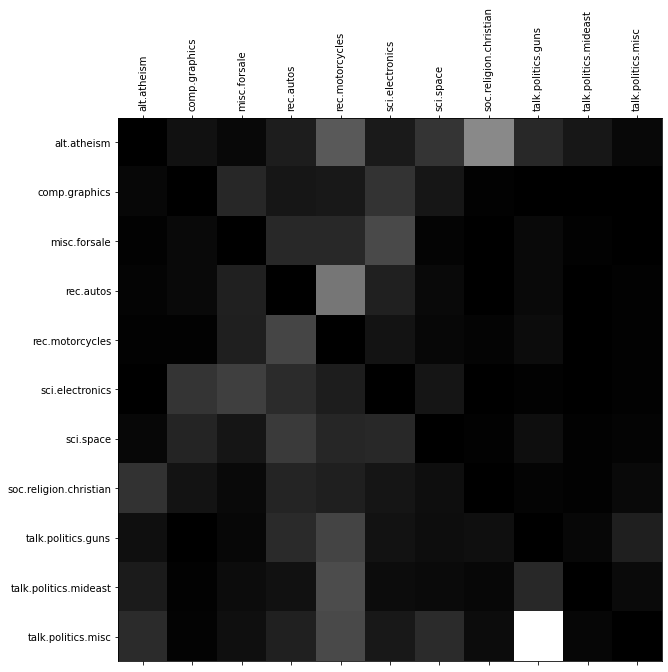

In [49]:
plot_confusion_matrix(y_test,y_pred_test)

- Welchen F1-Score erzielst du auf dem Testset?

In [50]:
f1_score(y_test, y_pred_test, average="macro")

0.7400261525752353

In [51]:
# categories

- Welche Kategorien werden `X_test[13], X_test[42], X_test[66]` und `X_test[333]` zugewiesen

In [ ]:
print(categories[y_test[13]], "\n", X_test[13])
print("--------------")
print(categories[y_test[42]], "\n", X_test[42])
print("--------------")
print(categories[y_test[66]], "\n", X_test[66])
print("--------------")
print(categories[y_test[333]], "\n", X_test[333])

finale Version

In [11]:
import tensorflow as tf

In [58]:
grid_search.best_estimator_.decision_function()

array([[ 3.84257295,  0.75865687, -0.25212547, ...,  8.00858009,
         2.77688575,  4.8500177 ],
       [ 9.17292155,  3.86998758, -0.27214063, ...,  7.92535288,
         0.78264686,  5.90795982],
       [ 8.15460912,  0.73503961, -0.2836848 , ..., 10.30303001,
         7.11941346,  9.23238666],
       ...,
       [-0.28476862,  5.97915359, 10.312516  , ...,  1.73404493,
         0.72281917,  3.7393389 ],
       [-0.26891993,  8.1411147 ,  7.12364137, ...,  3.78940658,
         1.75380038,  2.77808481],
       [ 8.17401172,  0.74696533, -0.27980539, ...,  7.17528367,
         5.93989973, 10.30302679]])

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [7]:
X = TfidfVectorizer().fit_transform(X_train)

In [15]:
tf.compat.v1.disable_eager_execution()

In [18]:
X.shape

(6199, 52425)

In [21]:

X_tf = tf.TensorArray(X,X.shape)

In [22]:
# max_features =  6199
# maxlen =  52425
# batch_size = 32


# print('Pad sequences (samples x time)')
# input_train = pad_sequences(X_train, maxlen=maxlen)
# # '


In [29]:
model = tf.keras.models.Sequential([

    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
    
])

In [26]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_tf, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: inputs=<tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x00000169BB392C40>

In [22]:
type(X)

sklearn.feature_extraction.text.TfidfVectorizer